# Faster RCNN

## Goals:
- Training/Inference available to user
- Inference:
    - ...
- Training:
    - User submitted parameters:
        - k: number of anchors
        - pretrained network (ZF/VGG16/user submitted)
        - n: spatial window size
        - window map output dimension (ZF:256-d/VGG16:512d)
        - scale/aspect ratios of anchors
        - IoU limits (upper and lower) for flagging anchors
        - loss functions: one for Lcls, one for Lreg, one for the combination of the two
        - optimizers: one for RPN branch and one for CLS branch
        - mini-batch size of randomly sampled anchors (default 256)
        - ratio of positive to negative anchors in mini-batch (default 1:1)
        - new layer initilization functions (default Gauss 0mean, 0.01std)
        - weight initialization for the base (pretrained) model

## Components


In [143]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.7 MB/s 


### Data:
- PASCAL VOC 2007:
    - trained on VOC 2007 trainval
    - test on testset

In [4]:
import tensorflow_datasets as tfds

In [5]:
def get_original_data_info():
    data, info = tfds.load("voc", with_info=True)
    test_ds, train_ds, valid_ds = data.values()
    return test_ds, train_ds, valid_ds, info
test_ds, train_ds, valid_ds, info = get_original_data_info()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incompleteVHDGP4/voc-test.tfrecord


  0%|          | 0/4952 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incompleteVHDGP4/voc-train.tfrecord


  0%|          | 0/2501 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incompleteVHDGP4/voc-validation.tfrecord


  0%|          | 0/2510 [00:00<?, ? examples/s]

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


In [6]:
print(info)
classlbls = info.features['labels']

tfds.core.DatasetInfo(
    name='voc',
    version=4.0.0,
    description='This dataset contains the data from the PASCAL Visual Object Classes Challenge
2007, a.k.a. VOC2007, corresponding to the Classification and Detection
competitions.
A total of 9963 images are included in this dataset, where each image
contains a set of objects, out of 20 different classes, making a total of
24640 annotated objects.
In the Classification competition, the goal is to predict the set of labels
contained in the image, while in the Detection competition the goal is to
predict the bounding box and label of each individual object.
annotations.',
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'labels': Sequence(ClassLabel(shape=(), dtype=tf.int64, num_classes=20)),
        'labels_no_difficult': Sequence(ClassLabel(shape=(), dtype=t

In [7]:
def print_bbox_formats():
    print("Axis: x -> left-right; y -> up-down")
    print("Reference frame (x,y): top-left = (0,0); bot-right = (img_W,img_H)")
    print("*All values normalized b/w [0,1]*")
    print("VOC:    (ymin, xmin, ymax, xmax)")
    print("RCNN:   (center_x, center_y, width, height)")
    print("Pyplot: (xmin, ymin, width, height)")

In [8]:
# SWAPPING SPLIT AXIS FROM 1 to -1: see if no longer need reshape

In [9]:
def voc_to_rcnn_bbox(voc_bbox):
    # Note: top left is (0,0), bot right is (max,max)
    #   - values are normalized b/w [0,1]
    #ymin, xmin, ymax, xmax = voc_bbox[:,0], voc_bbox[:,1], voc_bbox[:,2], voc_bbox[:,3]
    ymin, xmin, ymax, xmax = tf.split(voc_bbox, num_or_size_splits=4, axis=-1)
    # Rcnn is in box-center, width, height format
    #   - values are still normalized
    center_x = (xmin + xmax) / 2.
    center_y = (ymin + ymax) / 2.
    width = xmax - xmin
    height = ymax - ymin
    return tf.concat([center_x, center_y, width, height], axis=-1)

In [10]:
def rcnn_to_voc_bbox(rcnn_bbox):
    # Note: top left is (0,0), bot right is (max,max)
    #   - values a normalized b/w [0,1]
    center_x, center_y, width, height = tf.split(rcnn_bbox, num_or_size_splits=4, axis=-1)
    # Pyplot is in ((xmin, ymin), width, height) format
    #   - NOT normalized for plotting, will leave normalized for now
    #   - for imshow: top-left is (0,0)
    xmin = center_x - width/2.
    ymin = center_y - height/2.
    xmax = center_x + width/2.
    ymax = center_y + height/2.
    return tf.concat([ymin, xmin, ymax, xmax], axis=-1)

In [11]:
@tf.function
def preprocess_data(sample):
    image = sample['image']
    bboxes = sample['objects']['bbox']
    bboxes = voc_to_rcnn_bbox(bboxes)
    labels = sample['objects']['label']
    return {'image': image, 'bboxes': bboxes, 'labels': labels}

In [27]:
def rcnn_to_pyplot_norm_bbox(rcnn_bbox):
    # Note: top left is (0,0), bot right is (max,max)
    #   - values a normalized b/w [0,1]
    center_x, center_y, width, height = tf.split(rcnn_bbox, num_or_size_splits=4, axis=-1)
    # Pyplot is in ((xmin, ymin), width, height) format
    #   - NOT normalized for plotting, will leave normalized for now
    #   - for imshow: top-left is (0,0)
    new_xmin = center_x - width/2.
    new_ymin = center_y - height/2.

    # For cross-boundary crops, easier to go from voc -> pyplot
    voc_bbox = rcnn_to_voc_bbox(rcnn_bbox)
    plt_bbox = voc_to_pyplot_norm_bbox(voc_bbox)
    return plt_bbox

In [28]:
# UNTESTED
def voc_to_pyplot_norm_bbox(voc_bbox):
    # Note: top left is (0,0), bot right is (max,max)
    #   - values are normalized b/w [0,1]
    # Crop cross-boundary boxes for plotting
    voc_bbox = tf.clip_by_value(voc_bbox, 0., 1.)
    ymin, xmin, ymax, xmax = tf.split(voc_bbox, num_or_size_splits=4, axis=-1)
    # Pyplot is in ((xmin, ymin), width, height) format
    #   - NOT normalized for plotting, will leave normalized for now
    width = xmax - xmin
    height = ymax - ymin
    return tf.concat([xmin, ymin, width, height], axis=-1)

In [14]:
test_ds, train_ds, valid_ds, _ = get_original_data_info()
test_ds = test_ds.map(preprocess_data)
train_ds = train_ds.map(preprocess_data)
valid_ds = valid_ds.map(preprocess_data)

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_rcnn_bboxes(ax, image, bboxes, labels, show_labels=True,
                     pred_bboxes=None, pred_labels=None):
    ax.imshow(image)
    ax.xaxis.tick_top()
    H, W, _ = image.shape
    plt_bboxes = rcnn_to_pyplot_norm_bbox(bboxes)
    for bbox,label in zip(plt_bboxes, labels):
        plt_xmin, plt_ymin, width, height = bbox
        rect = patches.Rectangle((plt_xmin*W, plt_ymin*H), width*W, height*H,
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        if show_labels:
            ax.text(plt_xmin*W, plt_ymin*H, classlbls.int2str(label), c='w',
                    bbox=dict(facecolor='black', edgecolor='black', boxstyle='round'))
    
    if (pred_bboxes is not None) and (pred_labels is not None):
        plt_bboxes = rcnn_to_pyplot_norm_bbox(pred_bboxes)
        for bbox,label in zip(plt_bboxes, pred_labels):
            plt_xmin, plt_ymin, width, height = bbox
            rect = patches.Rectangle((plt_xmin*W, plt_ymin*H), width*W, height*H,
                                    linewidth=1, edgecolor='y', facecolor='none')
            ax.add_patch(rect)
            if show_labels:
                ax.text(plt_xmin*W, plt_ymin*H, classlbls.int2str(label), c='w',
                        bbox=dict(facecolor='black', edgecolor='black', boxstyle='round'))

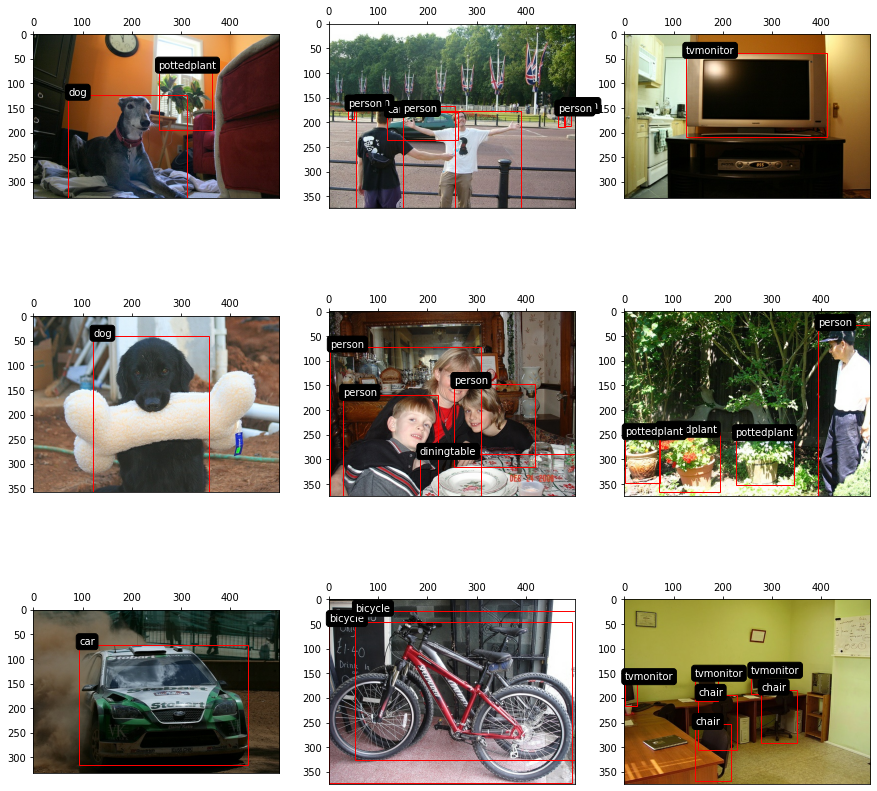

In [16]:
sample = next(iter(test_ds.take(1)))
fig, axs = plt.subplots(3,3,figsize=(15,15)); axs = axs.flatten()
for ax,sample in zip(axs,test_ds.take(9)):
    plot_rcnn_bboxes(ax, **sample)

### Shared body:
- The first network to process the images and produce features that are then fed into the RPN and Classifier head
- Pretrained on ImageNet
- Archecture of network will determine the receptive field size given the n x n sliding window over the feature layer's outputs

In [17]:
pretrained = tf.keras.applications.vgg16.VGG16(
    include_top = False, weights='imagenet'
)
pretrained.trainable = False # All 13 conv layers are shared 

58900480/58889256 [==============================] - 1s 0us/step


In [18]:
for sample in train_ds.take(1):
    image = sample['image']
    bboxes = sample['bboxes']
    labels = sample['labels']
    print("Image shape:", image.shape)
    features = pretrained(image[tf.newaxis, ...])
    print("Pretrained output shape:", features.shape)

Image shape: (480, 389, 3)
Pretrained output shape: (1, 15, 12, 512)


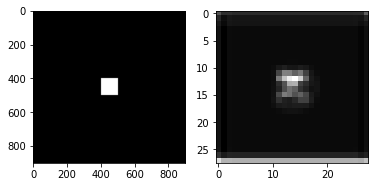

In [19]:
# Determine receptive field size:
size = 100
test = np.ones((size,size))
test = np.pad(test, 500-size)
test = np.repeat(test[..., np.newaxis], 3, axis=2)

fig, ax = plt.subplots(1,2); ax = ax.flatten()
ax[0].imshow(test)
testout = pretrained(test[np.newaxis, ..., np.newaxis])
ax[1].imshow(tf.reduce_sum(testout[0], axis=-1), cmap='gray')

In [20]:
# Approximate method of determining receptive field size:
#   - appears that ratio is 3:100 for receptive:base pixels
#   - need better method for determining since paper gives ratio of 3:228
test_image_1 = tf.zeros((1, 100, 100, 3))
test_image_2 = tf.zeros((1, 1000, 1000, 3))

out_1 = pretrained(test_image_1)
out_2 = pretrained(test_image_2)

print(out_1.shape)
print(out_2.shape)

#basetoreceptive = 3/100.
basetoreceptive = 3/228.

(1, 3, 3, 512)
(1, 31, 31, 512)


### RPN
    - considers provided anchors
    - proposes based off of IoU limits

In [21]:
class RPN(keras.Model):
    def __init__(self, n=3, k=9):
        super(RPN, self).__init__()

        self.k = k
        self.n = n

        self.windowmap = layers.Conv2D(512, (n,n), activation="relu",
                                       padding='same', name="windowmap")
        self.reglayer = layers.Conv2D(4*k, (1,1), activation="relu",
                                      padding='same', name="reglayer")
        self.clslayer = layers.Conv2D(2*k, (1,1), activation="sigmoid",
                                      padding='same', name="clslayer")
        
    def clsloss(self, p, p_tar):
        loss = keras.losses.BinaryCrossentropy(p, p_tar)
        return loss

    def call(self, image_features):
        x = self.windowmap(image_features)

        reg = self.reglayer(x)
        regshape = tf.shape(reg)
        reg = tf.reshape(reg, (regshape[1], regshape[2], 9, 4))

        cls = self.clslayer(x)
        clsshape = tf.shape(cls)
        cls = tf.reshape(cls, (clsshape[1], clsshape[2], 9, 2))

        return [reg, cls]

In [22]:
rpn = RPN()
reg, cls = rpn(features)
print(features.shape)
print(reg.shape) # Note: total of W*H*k anchors
print(cls.shape)

(1, 15, 12, 512)
(15, 12, 9, 4)
(15, 12, 9, 2)


### Temp Position Below:
    - will be inserted into final class

#### IoU Rules:
- Since the output of the network (reg) will correspond each anchor w/ ONE object, each anchor needs to be associated with each ground truth box until the point of calculating the loss specifically.
- Anchor labels format :: (H, W, k, #gtruthbboxes, 2)
- Positive:
    - (i) If IoU > 0.7 w/ ANY gtruth bbox
    - ELSE IF NONE of anchors IoU > 0.7 w/ ANY gtruth bbox
    - (ii) Anchor/Anchors w/ highest IoU w/ ANY gtruth bbox
    - Note: It is possible for a set of anchors to have passed to (ii) where at least one of the anchors is flagged Positive w/ IoU < 0.3
- Negative:
    - (i) IF NON-POSITIVE anchor AND IF IoU < 0.3 for ALL gtruth bboxes
- Neither:
    - Ignore during training

#### Compartmentalized methods

In [130]:
def parameterize_rcnn_bbox(input_bbox, anchor_bbox):
    # Note: top left is (0,0), bot right is (H_max,W_max)
    #   - input in rcnn format -- (center_x, center_y, width, height)
    #   - values are normalized b/w [0,1]
    center_x, center_y, width, height = tf.split(input_bbox, num_or_size_splits=4, axis=-1)
    center_x_a, center_y_a, width_a, height_a = tf.split(anchor_bbox, num_or_size_splits=4, axis=-1)
    # In case of proposed 0 width or 0 height, add small pos. quantity
    #   - ie. log(0) error
    #   - since reglayer activation is relu, no worries about negative input into log
    width = width + 1e-10
    height = height + 1e-10
    # Parameterization is scale invariant (ie. norm/not norm vals are acceptable)
    tx = (center_x - center_x_a) / width_a
    ty = (center_y - center_y_a) / height_a
    tw = tf.math.log(width / width_a)
    th = tf.math.log(height / height_a)
    return tf.concat([tx, ty, tw, th], axis=-1)

In [131]:
def create_rcnn_anchors(feat_H, feat_W,
                        scales=[128., 256., 512.], aspects=[1., .5, 2.]):
    # Create anchor values using linspace -> meshgrid
    _, feat_H, feat_W, _ = tf.shape(features) # features :: (batch_dim=1, feat_H, feat_W, feat_C)
    
    # Generate relative sized anchor centers
    #   - creating matrix of anchor over feat_H x feat_W space
    H_linspace = tf.linspace(start=0., stop=1., num=feat_H)
    W_linspace = tf.linspace(start=0., stop=1., num=feat_W)
    anchor_centers = tf.stack(tf.meshgrid(W_linspace, H_linspace), axis=-1) # :: (feat_H, feat_W, 2)
    
    # Generate relative sized height and width of anchor
    #   - meshgrid generates combinations of scales x aspects
    anchor_W, anchor_Hscales = tf.meshgrid(scales, aspects)
    anchor_H = anchor_W * anchor_Hscales
    anchor_W_H = tf.stack([anchor_W, anchor_H], axis=-1)
    anchor_W_H = tf.reshape(anchor_W_H, [-1, 2]) # :: (9,2)
    anchor_W_H = anchor_W_H * tf.concat([1./tf.cast(img_W, tf.float32),
                                        1./tf.cast(img_H, tf.float32)], axis=0)
    
    # Get complete relative sized anchor bboxes 4 coords
    #   - broadcast for compatible shapes
    k = 9
    # anchor_centers :: (feat_H, feat_W, 2) --> (feat_H, feat_W, k, 2)
    # anchor_W_H :: (k, 2) --> (feat_H, feat_W, k, 2)
    # anchor_rcnn_bboxes :: (feat_H, feat_W, k, 4)
    anchor_centers = tf.broadcast_to(anchor_centers[:, :, tf.newaxis, :], shape=[feat_H, feat_W, k, 2])
    anchor_W_H = tf.broadcast_to(anchor_W_H, shape=[feat_H, feat_W, k, 2])
    anchor_rcnn_bboxes = tf.concat([anchor_centers, anchor_W_H], axis=-1) # :: (feat_H, feat_W, 9, 4)

    return anchor_rcnn_bboxes

In [132]:
def generate_crossbound_mask(anchor_voc_bboxes):
    # Generate cross-boundary anchor mask to ignore during training
    #   - recall: VOC format - (ymin, xmin, ymax, xmax)
    #   - recall: values are normalized (ie. check for >1 and <0)
    crossbounds_mask = (anchor_voc_bboxes > 1.) | (anchor_voc_bboxes < 0.) # :: (feat_H, feat_W, k, 4)
    crossbounds_mask = tf.reduce_any(crossbounds_mask, axis=-1) # :: (feat_H, feat_W, k)
    crossbounds_mask = ~crossbounds_mask # TRUE if mask doesn't extend, FALSE if out of bounds
    return crossbounds_mask

In [133]:
def generate_voc_anchor_labels(anchor_voc_bboxes, gtruth_voc_bboxes, crossbound_mask=None):
    # Calculate IoU b/w all anchors and all gtruth bboxes:
    #   - Note: L_IoU = 1 - IoU
    anchor_voc_bboxes = anchor_voc_bboxes[:, :, :, tf.newaxis, :] # :: (feat_H, feat_W, k, 1, 4)
    IoUs = 1. - tfa.losses.giou_loss(gtruth_voc_bboxes, anchor_voc_bboxes, mode='iou') # :: (feat_H, feat_W, k, # of gtruth bboxes)
    
    # Flag the anchors according to IoU
    #   - '_pergt' :: (feat_H, feat_W, k, # of gtruth bboxes)
    #       - ie. retains info for each gtruth bbox wrt each anchor
    #   - '_anygt' :: (feat_H, feat_W, k)
    #       - ie. condition is true/false wrt ANY of the k anchors
    #   - '_allgt' :: (feat_H, faet_W, k)
    #       0 ie. condition is true/false wrt ALL of the k anchors
    greaterp7_pergt = IoUs > 0.7
    greaterp7_anygt = tf.reduce_any(greaterp7_pergt, axis=-1) # (i)
    lesserp3_pergt  = IoUs < 0.3
    lesserp3_allgt = tf.reduce_all(lesserp3_pergt, axis=-1)
    
    # Maximum IoU across all k anchors (per position) and all gtruth bboxes
    #   - flag each anchor true if it equals max iou in anchor set
    maxious = tf.reduce_max(IoUs, axis=[-1,-2]) # :: (feat_H, feat_W)
    maxiousflags = (maxious[..., tf.newaxis, tf.newaxis] == IoUs) # :: (featu_H, feat_W, k, # of gtruth bboxes)
    
    # Below handles the two positive cases
    #   - Note: python bitwise operators work as logical operators w/ tf bools
    #   - positiveflags(_pergt/_anygt) :: (feat_H, feat_W, k[, # of gtruth bboxes])
    #   - negativeflags(_pergt/_allgt) :: (feat_H, feat_W, k[, # of gtruth bboxes])
    
    # "Anchor is positive if IoU > 0.7 OR none of the anchors in the set have IoU > 0.7 but are max IoU"
    #   - corresponds to cond. for Positive (i)/(ii)
    #   - APPLY crossbound masking
    positiveflags_pergt = greaterp7_pergt | (~greaterp7_anygt[..., tf.newaxis] & maxiousflags)
    if crossbound_masking: positiveflags_pergt = crossbounds_mask[..., tf.newaxis] & positiveflags_pergt
    positiveflags_anygt = tf.reduce_any(positiveflags_pergt, axis=-1)
    
    # "Anchor is negative if none of the anchors in the set are positive AND the IoU < 0.3 for all gtruth bboxes"
    #   - corresponds to cond. for Negative (i)
    #   - APPLY crossbound masking
    #   - Note: a corrolary to the rules is that IFF ANY anchor in the set is negative, ALL will be negative 
    negativeflags_allgt = ~positiveflags_anygt & lesserp3_allgt 
    if crossbound_masking: negativeflags_allgt = crossbounds_mask & negativeflags_allgt
    negativeflags_pergt = tf.repeat(negativeflags_allgt[..., tf.newaxis], num_gt_bboxes, axis=-1)
    
    # "Anchor is neither positive nor negative"
    #   - corresonds to cond. for Neither
    neitherflags_pergt = ~positiveflags_pergt & ~negativeflags_pergt

    return (positiveflags_pergt, positiveflags_anygt, negativeflags_allgt, negativeflags_pergt, neitherflags_pergt)

In [134]:
def calc_reg_loss(reg_paramtzd, gtruth_paramtzd):
    # Handle RPN 'reg' loss
    #   - paper specifies "Robust Loss (L1)", Huber is close enough
    reg_loss = keras.losses.huber(gtruth_paramtzd, reg_paramtzd)
    reg_loss = tf.reduce_mean(reg_loss)
    return reg_loss

In [135]:
def calc_cls_loss(cls, sampled_indices,
                  pos_samples_cnt, neg_samples_cnt):
    # Handle RPN 'cls' loss
    #   - binary crossentropy
    #   - Note: can drop 4th index in indices since cls not gtruth specific
    #   - Note: unnecessary to use gather for positiveflags/negativeflags since
    #       we know the values [1.,0.]/[0.,1.] and the ordering (<=128pos, rest neg)
    cls_sampled = tf.gather_nd(cls, sampled_indices[:, :3])
    cls_tar_pos = tf.repeat([[1.,0.]], pos_samples_cnt, axis=0)
    cls_tar_neg = tf.repeat([[0.,1.0]], neg_samples_cnt, axis=0)
    cls_tar = tf.concat([cls_tar_pos, cls_tar_neg], axis=0)
    cls_loss = keras.losses.binary_crossentropy(cls_tar,
                                                cls_sampled,
                                                from_logits=False)
    cls_loss = tf.reduce_mean(cls_loss)
    return cls_loss

In [136]:
def gather_minibatch(positiveflags_pergt, negativeflags_pergt,
                     reg_paramtzd, gtruth_paramtzd,
                     total_samples=256, desired_positive=128):
    # Implementation of mini-batch random sampling of 256 anchors
    #   - Note: still wrt each ground truth
    num_pos_samples = tf.reduce_sum(tf.cast(positiveflags_pergt, tf.int32))
    pos_samples_cnt = tf.math.minimum(desired_positive, num_pos_samples)
    neg_samples_cnt = total_samples - pos_samples_cnt
    
    # Randomly sample positive flag indices
    pos_indices = tf.where(positiveflags_pergt)
    pos_indices = tf.random.shuffle(pos_indices, 
                                    seed=1337, 
                                    name="Mini-batch sampling (+)")
    pos_indices = pos_indices[:pos_samples_cnt]
    
    # Randomly sample neg flag indices
    neg_indices = tf.where(negativeflags_pergt)
    neg_indices = tf.random.shuffle(pos_indices,
                                    seed=1337,
                                    name="Mini-batch sampling (neg)")
    neg_indices = neg_indices[:neg_samples_cnt]
    
    # Sample gtruth_paramtzd and reg_paramtzd according to indices
    #   - Note: don't need 4th index when gathering RPN reg output since
    #       the output is the same for all gtruths (ie. not gtruth specific)
    #       - ie. the network doesnt output a bbox per gtruth, only per anchor
    sampled_indices = tf.concat([pos_indices, neg_indices], axis=0)
    gtruth_paramtzd = tf.gather_nd(gtruth_paramtzd, sampled_indices)
    reg_paramtzd = tf.gather_nd(reg_paramtzd, sampled_indices[:, :3])

    return (reg_paramtzd, gtruth_paramtzd, sampled_indices, pos_samples_cnt, neg_samples_cnt)

#### Combined methods

In [178]:
def get_rpn_bboxes_and_losses(reg, cls, features, 
                              gtruth_rcnn_bboxes):
    # Note: gtruth bboxes from dataset are in rcnn format
    #   - DEBUG: Inconvenient if axes match - hard set to 3
    gtruth_rcnn_bboxes = gtruth_rcnn_bboxes[:3, :] # Leftover from exposed code testing :: (# gtruth bboxes, 4)
    num_gt_bboxes, _ = tf.shape(gtruth_rcnn_bboxes)
                                
    # Step 1) Generate anchor bboxes
    _, feat_H, feat_W, _ = tf.shape(features)
    anchor_rcnn_bboxes = create_rcnn_anchors(feat_H, feat_W)
    
    # Convert from rcnn format to voc format
    anchor_voc_bboxes = rcnn_to_voc_bbox(anchor_rcnn_bboxes)
    gtruth_voc_bboxes = rcnn_to_voc_bbox(gtruth_rcnn_bboxes)
    
    # Step 2) Generate anchor labels
    #   - w/ Optional cross-bound masking
    crossbound_masking = False
    crossbound_mask = generate_crossbound_mask(anchor_voc_bboxes)
    
    (positiveflags_pergt, positiveflags_anygt, 
    negativeflags_allgt, negativeflags_pergt, 
    neitherflags_pergt) = generate_voc_anchor_labels(anchor_voc_bboxes, gtruth_voc_bboxes, crossbound_mask)
    
    # Step 3) Parameterize reg output and gtruth bboxes 
    reg_paramtzd = parameterize_rcnn_bbox(reg, anchor_rcnn_bboxes)
    gtruth_paramtzd = parameterize_rcnn_bbox(gtruth_rcnn_bboxes, anchor_rcnn_bboxes[:, :, :, tf.newaxis, :])
    
    # Step 4) Randomly sample a mini-batch of training samples
    (reg_paramtzd, gtruth_paramtzd, sampled_indices,
    pos_samples_cnt, neg_samples_cnt) = gather_minibatch(positiveflags_pergt, negativeflags_pergt,
                                                        reg_paramtzd, gtruth_paramtzd)
    
    # Step 5) Calculate reg + cls loss and combine
    lambd = 1.0
    reg_loss = calc_reg_loss(reg_paramtzd, gtruth_paramtzd)
    cls_loss = calc_cls_loss(cls, sampled_indices, pos_samples_cnt, neg_samples_cnt)
    #total_loss = cls_loss + lambd * reg_loss
    
    return reg_paramtzd, {"cls_loss": cls_loss, "reg_loss": reg_loss}

In [179]:
get_rpn_bboxes_and_losses(reg, cls, features,
                          bboxes)

(<tf.Tensor: shape=(256, 4), dtype=float32, numpy=
 array([[ 10.887279  ,   2.0083916 ,   2.3787644 ,  -1.0554823 ],
        [  4.900198  ,  -0.26785713,   1.7737646 ,   0.47425032],
        [ -0.0690696 ,   0.        , -23.300596  , -23.783537  ],
        ...,
        [ -0.0690696 ,  -0.6026786 ,   0.42597657, -23.09039   ],
        [ -0.69069606,  -0.80357146,   2.3788369 , -23.09039   ],
        [ -0.62162644,   0.        , -23.300596  ,   0.38522497]],
       dtype=float32)>,
 {'cls_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4665346>,
  'reg_loss': <tf.Tensor: shape=(), dtype=float32, numpy=9.07102>})

In [165]:
## Paper gives example of 1000x600 input w/ 60x40x9 ~ 20,000 anchors
##   where 6,000 are not cross-boundary (ie. 6000/20000 = 30% valid)
#a = tf.reduce_prod(tf.shape(crossbounds_mask))
#b = tf.reduce_sum(tf.cast(crossbounds_mask, tf.int32))
#print(image.shape)
#print(features.shape)
#print(a.numpy(), b.numpy(), (b / a).numpy())

In [166]:
reg.shape, cls.shape

(TensorShape([15, 12, 9, 4]), TensorShape([15, 12, 9, 2]))

In [167]:
N = 10
vals, indices = tf.math.top_k(tf.reshape(cls[..., 0], [-1]), k=N)
obj_reg = tf.gather_nd(tf.reshape(reg, [-1, 4]), indices[...,tf.newaxis])

In [168]:
print_bbox_formats()

Axis: x -> left-right; y -> up-down
Reference frame (x,y): top-left = (0,0); bot-right = (img_W,img_H)
*All values normalized b/w [0,1]*
VOC:    (ymin, xmin, ymax, xmax)
RCNN:   (center_x, center_y, width, height)
Pyplot: (xmin, ymin, width, height)


TensorShape([480, 389, 3])

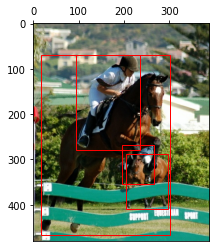

In [169]:
fig, ax = plt.subplots()
plot_rcnn_bboxes(ax, image, bboxes, labels, show_labels=False,
                 pred_bboxes=obj_reg, pred_labels=None)
image.shape

In [170]:
print_bbox_formats()

Axis: x -> left-right; y -> up-down
Reference frame (x,y): top-left = (0,0); bot-right = (img_W,img_H)
*All values normalized b/w [0,1]*
VOC:    (ymin, xmin, ymax, xmax)
RCNN:   (center_x, center_y, width, height)
Pyplot: (xmin, ymin, width, height)


### RoI Pooling

In [171]:
# Inputs:
#   - RPN BBoxes (reg -- rcnn format)
#   - Features (from shared feature extractor network (VGG) )
#
# Outputs:
#   - RoI Feature Vectors


class RoIPool(keras.Model):
    def __init__(self):
        super(RoIPool, self).__init__()

        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(32)
        self.fc2 = layers.Dense(64)

        self.crop_height = 64
        self.crop_width  = 64

    def crop_rois(self, reg, features):
        # reg :: (N(=10), 4) -- rcnn format
        # features :: (1, feat_H, feat_W, 512)

        # crop_and_resize:
        #   - expects bbox coords in (ymin, xmin, ymax, xmax) VOC format
        #   - expects bbox coords to be normalized [0,1]
        #   - box_indices refer to which element in batch, only one elem. so 0 
        voc_reg = rcnn_to_voc_bbox(reg)
        box_indices = tf.zeros([tf.shape(reg)[0]], tf.int32)
        crop_size = [self.crop_height, self.crop_width]
        rois_cropped_and_resized = tf.image.crop_and_resize(image=features, 
                                                            boxes=voc_reg,
                                                            box_indices=box_indices,
                                                            crop_size=crop_size)
        return rois_cropped_and_resized
        
    def pool_rois(self, rois):
        # rois :: (N(=10), crop_height, crop_width, 512)
        # pooled_roi :: (N(=10), 7, 7, 512)

        ksize = [self.crop_height // 7, self.crop_width // 7]
        strides = ksize
        padding = "SAME"

        rois_pooled = tf.nn.max_pool2d(input=rois,
                                       ksize=ksize,
                                       strides=strides,
                                       padding=padding)
        return rois_pooled

    def call(self, inputs):
        # inputs -- [features, obj_reg]
        # image_features :: (1, None, None, 512)
        # obj_reg :: (~2000, 4)
        features, obj_reg = inputs
        rois_cropped_and_resized = self.crop_rois(obj_reg, features)
        rois_pooled = self.pool_rois(rois_cropped_and_resized)

        x = self.flatten(rois_pooled) # :: (~2000, 7 * 7 * 512)
        x = self.fc1(x)
        x = self.fc2(x)
        return x # :: (~2000, 64)

In [172]:
roipool = RoIPool()
# NOTE: Should be passing all positive flagged reg's to the classifier
#   - should be ~2000 rois, if too many, implement NMS
res = roipool([features, obj_reg])
res.shape

TensorShape([10, 64])

### Classifier

In [173]:
inputs = keras.Input(shape=(64))
output = layers.Dense(1000, activation="softmax")(inputs)
# Note: could also include an additional bbox regressor
#   as is the case in Fast RCNN
headclassifier = keras.Model(inputs=inputs, outputs=output)

In [174]:
headclassifier(res)

<tf.Tensor: shape=(10, 1000), dtype=float32, numpy=
array([[1.0000000e-03, 1.0000000e-03, 1.0000000e-03, ..., 1.0000000e-03,
        1.0000000e-03, 1.0000000e-03],
       [7.5190779e-05, 1.6051465e-05, 1.7252794e-04, ..., 4.7652645e-04,
        1.2827058e-05, 9.8933140e-04],
       [6.1192945e-06, 1.1532730e-05, 5.0229250e-05, ..., 2.3800886e-04,
        2.4240093e-05, 2.6324296e-03],
       ...,
       [1.0000000e-03, 1.0000000e-03, 1.0000000e-03, ..., 1.0000000e-03,
        1.0000000e-03, 1.0000000e-03],
       [2.2733971e-06, 2.0242960e-07, 2.5750538e-05, ..., 1.1704035e-05,
        1.0649819e-05, 5.6195870e-07],
       [1.0000000e-03, 1.0000000e-03, 1.0000000e-03, ..., 1.0000000e-03,
        1.0000000e-03, 1.0000000e-03]], dtype=float32)>

### Full Model

In [192]:
class FasterRCNN(keras.Model):
    def __init__(self):
        super(FasterRCNN, self).__init__()
        self.base = pretrained
        self.rpn = RPN()
        self.roipool = RoIPool()
        self.headclassifier = headclassifier

    # TODO: Figure out call/train_step divisions
    #   - ie. most efficient spot for loss calc.
    def train_step(self, input_image, gtruth_voc_bboxes):
        # input_image :: (1, img_H, imgW, 3)

        # features :: (1, feat_H, feat_W, 512)
        features = self.base(input_image)

        # reg :: (feat_H, feat_W, 9, 4)
        # cls :: (feat_H, feat_W, 9, 2)
        reg, cls = self.rpn(features)

        # Perform parameterization ops on reg
        lambd = 1.0
        rpn_pred_bboxes, losses = get_rpn_bboxes_and_losses(reg, cls, features,
                                                            gtruth_voc_bboxes)
        cls_loss, reg_loss = losses["cls_loss"], losses["reg_loss"]
        rpn_loss = cls_loss + lambd * reg_loss
        self.add_loss(lambda: rpn_loss)

        # bboxes :: (~2000, 4)
        # roifeaturevectors:: (~2000, 64)
        roifeaturevectors = self.roipool([features, rpn_pred_bboxes])

        # class_preds :: (~2000, 1000)
        class_preds = self.headclassifier(roifeaturevectors)

        return [class_preds, rpn_pred_bboxes]

    #def call():
        #pass

In [193]:
fasterrcnn = FasterRCNN()
fasterrcnn.train_step(image[tf.newaxis,...], bboxes)

[<tf.Tensor: shape=(256, 1000), dtype=float32, numpy=
 array([[1.5821826e-04, 1.0025742e-04, 6.1655819e-04, ..., 5.1098631e-04,
         9.3594368e-04, 5.6521810e-04],
        [1.0000000e-03, 1.0000000e-03, 1.0000000e-03, ..., 1.0000000e-03,
         1.0000000e-03, 1.0000000e-03],
        [1.0000000e-03, 1.0000000e-03, 1.0000000e-03, ..., 1.0000000e-03,
         1.0000000e-03, 1.0000000e-03],
        ...,
        [1.0000000e-03, 1.0000000e-03, 1.0000000e-03, ..., 1.0000000e-03,
         1.0000000e-03, 1.0000000e-03],
        [1.4645249e-03, 2.2599279e-05, 2.7711196e-03, ..., 4.1132979e-04,
         6.3603125e-03, 2.2606846e-05],
        [1.0000000e-03, 1.0000000e-03, 1.0000000e-03, ..., 1.0000000e-03,
         1.0000000e-03, 1.0000000e-03]], dtype=float32)>,
 <tf.Tensor: shape=(256, 4), dtype=float32, numpy=
 array([[ -0.7597656 ,  -0.73660713, -23.300596  , -23.09039   ],
        [ -0.5525568 ,  -0.6026786 ,  -0.18574701, -23.09039   ],
        [ -0.5525568 ,  -0.80357146,   0.8660627

### Training RPNs:
- Training RPNs
    - stochastic gradient descent
    - each mini-batch arises from single image containing many positive and negative anchors
    - to prevent bias towards the more common negative anchors, randomly sample 256 anchors in image w/ up to 1:1 ratio
        - if fewer than 128 positive samples, pad mini-batch w/ negative ones
    - randomly initialize all new layers by drawing weights form zero-mean Gauss distrib. w/ std of 0.01
        - all other layers (ie. shared conv layers) are initialized by pretraining model for ImageNet classification (ie. fine-tune ZF, VGG, etc.)
    - lr = 0.001 for 60k mini-batches
    - lr = 0.0001 for next 20k mini-batches
    - momentum = 0.9
    - weight decay = 0.000

## Training: 4-Step Alternating Training
1. fine-tune pre-trained ImageNet model for RPN
2. train separate detection network by Fast R-CNN using generated proposals from step-1 (also a pre-trained ImageNet model)
3. use detector network to initialize RPN training, but fix the shared conv layers and only fine-tune the layers unique to RPN (now two networks share conv layers)
4. keeping shared layers fixed, fine-tune unique layers of Fast R-CNN


## Training: Approximate joint training
- RPN and Fast RCNN merged into one network
- in each SGD iteration, forward pass generates region proposals which are then passed to the Fast RCNN classifier and are treated as static givens (ie. no backprop path)
- backprop is the usual, where shared layers receive backprop signlas from both RPN loss and Fast RCNN loss, combined
- Note: soln is easy but ignored the derivative wrt the proposal boxes' coordinates that are also network responses, so is approximate
- should produce close results to method 1, but should be faster

## Training: Non-approximate joint training
- since the RoI Pooling Layer in FastRCNN accepts the conv features AND the predicted bounding boxes as inputs, grads should theoretically be valid wrt the box coordinates (ie. TF GradientTape should be able to handle the gradient across the bounding box outputs)
- would mean we need RoI pooling layer that is differentiable wrt the box coordinates (according to author, nontrivial problem)

## Implementation Details:
- re-scale images such that shorter side is s = 600 pixels
- for anchors, use 3 scales w/ box areas of 128^2, 256^2, 512^2 and 3 aspect ratios of 1:1, 1:2, 2:1
    - note that the bbox prediction is allowed to be larger than the underlying anchor in the receptive field
- for anchor boxes that cross image boundaries:
    - during training, ignore so they don't contribute to loss
        - for 1000 x 600 images, roughly 20000 anchors where 6000 are not cross-boundary
    - during testing, clip the proposals that are cross-boundary and return
- to reduce redundancy in overlapping proposals, adopt non-max suppression on proposals based on cls scores.
    - fix IoU thresh for NMS at 0.7, leaving ultimately about 2000 proposal regions per image
    - after NMS, use top-N ranked proposal regions for detection
    - Note: can be more lax during training and more strict during testing

## Experiments:
- Paper performed experiments on the PASCAL VOC detection benchmark
- as well as the MS COCO object detection dataset

### Fast R-CNN object detection network

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
pretrained = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet', classes=1000
)

In [ ]:
pretrained.summary()

In [ ]:
class RPN(keras.Model):
    def __init__(self, pretrained, n=3, k=9):
        super(RPN, self).__init__()
        self.pretrained = pretrained

        self.windowmap = keras.Conv2D(512, (n,n), activation="relu")
        self.reglayer = keras.Conv2D(4*k, (1,1))
        self.clslayer = keras.Conv2D(2*k, (1,1), activation="sigmoid")

    def call(self, input_images):
        x = self.pretrained(input_images)
        x = self.windowmap(input_images)
        reg = self.reglayer(x)
        cls = self.clslayer(x)

        

In [ ]:
class Classifier(keras.Model):
    def __init__(self, pretrained):
        super(Classifier, self).__init__()
        self.pretrained = pretrained
    
    def call(self, input_images):
        pass

In [ ]:
class FasterRCNN(keras.Model):
    def __init__(self, RPN, Classifier):
        super(FasterRCNN, self).__init__()
        self.RPN = RPN
        self.Classifier = Classifier

    def compile(self, optimizer):
        super(FasterRCNN, self).compile()
        self.optimizer = optimizer

    def call(self, input_images):
        rpn_out = self.RPN(input_images)
        classifier_out = self.Classifier(input_images)
        return tf.concat([rpn_out, classifier_out])

    def train_step(self, input_images):
        with tf.GradientTape() as tape:
            out = self(input_images)
            loss = loss_fn(out, tar)
        grads = tape.gradient(loss, self.trainable_weights)
        optimizer = self.optimizer.apply_gradients(
            zip(grads, self.trainable_weights)
        )
        return {"loss": loss}